In [1]:
from bs4 import BeautifulSoup
import lxml
import html5lib
import re
import json
import uuid
import glob
import pickle
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.cluster import KMeansClusterer, euclidean_distance
from gensim import corpora, models, utils
from numpy import array
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from pprint import pprint
from gensim import corpora
import re
from os.path import basename
import string
import logging
import pandas as pd
import numpy as np
import pyLDAvis
from empath import Empath
lexicon = Empath()

In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from scipy import sparse

In [3]:
%matplotlib inline

In [4]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [5]:
Topics_Name = ['register_sdk', 'new_features_suggestions', 'order_ship', 'thanks_reddit_A', 'switch_hub', 'localization', 'trouble_shooting', 'bluetooth_speaker', 'new_skill', \
              'music', 'smarthome_lock', 'amazon_tap', 'excite-joke', 'alexa_repeat_funny', 'chess_misc_not_clear', 'echo_setup', 'misc_A',\
              'harmony', 'code_skills_share', 'timer_alarm','misc_B', 'misc_C', 'smart_routine', 'light_room',\
              'bot_posts_subreddit', 'funny_questions_A', 'smart_light_gateway', 'hardware', 'Misc_D','fire_tv', 'wake_word','sonos_integration','funny_questions_B',\
              'amazon_media_streaming','call_intercome','movie_times','Misc_E','set_temperature', 'roku_plex', 'echo_speaker', 'subreddit_removed_submissions', 'mult_accts', 'Misc_F',\
              'alexa_comp','thanks_reddit_B', 'thanks_reddit_C','Misc_G','alexa_deal','Misc_H','alexa_price']

In [6]:
pd.set_option("display.max_colwidth", -1)
pd.set_option("display.max_columns", 100)

In [7]:
def display_closestwords_tsnescatterplot(model, word):
    #clear the entire current figure
    plt.clf()
    arr = np.empty((0,100), dtype='f')
    word_labels = [word]
    print(word_labels)
    # get close words
    close_words = model.similar_by_vector(word)
    print(len(close_words))
    print(model[word])
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.savefig('routine_AmazonEcho_vec_new')
    return()

In [8]:
def find_most_like(w2vfile, name_of_dataframe, num_of_embed, word):
    w2v = Word2Vec.load(w2vfile)
    vector = w2v.most_similar(word, topn=num_of_embed)
    name_of_dataframe = pd.DataFrame(vector, columns= ['word', 'score'])
    return name_of_dataframe

In [9]:
def normalize_topic(intersection, TextList):
    if len(TextList)==0:
        return 0
    else:
        return float(len(intersection)/(len(TextList)+len(intersection)))

In [10]:
def empathize(text, category):
    return(lexicon.analyze(text, categories=[category], normalize=True))

In [11]:
def find_intersection(TextList,LDAList):
    intersection = list(set(TextList) & set(LDAList))
    return normalize_topic(intersection,TextList)

In [12]:
def Tokinization(document):
    document = "".join(document)
    tokenizer = RegexpTokenizer(r'\w+')
    intermediate = tokenizer.tokenize(document)
    #stop words
    stop = stopwords.words('english')
    intermediate = [i for i in intermediate if i not in stop]
    #stemming
    lanste = LancasterStemmer()
    intermediate = [lanste.stem(i) for i in intermediate]
    return intermediate

In [13]:
def Preprocess(document):
    #document = document.encode('ascii','ignore')
    #remove http
    intermediate = document
    #join
    intermediate = "".join(document)
    intermediate = re.sub(r'htt\S+', '', intermediate)
    intermediate = re.sub(r'://t.co\S*', '', intermediate)
    # remove rts
    intermediate = re.sub(r'\brt\b','', intermediate)
    # remove digits
    intermediate = re.sub(r'\d+','', intermediate)
    # remove names after @
    # (screen names)
    intermediate = re.sub("@\\w+ *", '', intermediate)
    intermediate = re.sub(r'\b@\b','', intermediate)
    intermediate = unescape(intermediate)
    exclude = set(string.punctuation)
    intermediate = "".join(ch for ch in intermediate if ch is not exclude)
    
    intermediate = Tokinization(intermediate)
    return intermediate

In [14]:
def clean_LDA_topics(LDATopics):
    addch = "'"
    topics = []
    for i in range(0,len(LDATopics)):
        current_topic  = LDATopics[i][1]
        print(current_topic)
        newwords = []
        split_current_topic = []
        split_current_topic = current_topic.split("+")
        for j in range(0, len(split_current_topic)):
            newword = split_current_topic[j]
            print(split_current_topic)
            if j==0:
                newword = newword[7:-2]
            else:
                newword = newword[8:-2]
                newword = newword[:0] + newword[0:]
            newwords.append(newword)
        topics.append(newwords)
    return topics

In [15]:
def removeNone(intermediate):
    #remove None Values
    intermediate = ['' if v is None else v for v in intermediate]
    return intermediate

In [16]:
def unescape(s):
    s = s.replace("&gt;", "greater than")
    s = s.replace("&lt;3", "love")
    s = s.replace("&lt;", "less than")
    s = s.replace("&amp;", "and")
    s = s.replace("via", '')
    s = s.replace('\\n', '')
    s = s.replace('\\t', '')
    s = s.replace('\\r', '')
    return s

In [17]:
def list_to_string(string_list):
    conc_string = ''.join(str(n) for n in string_list)
    return conc_string

In [18]:
#source:https://markroxor.github.io/gensim/static/notebooks/topic_methods.html
def color_words(model, doc):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    # make into bag of words
    doc = model.id2word.doc2bow(doc)
    # get word_topics
    doc_topics, word_topics, phi_values = model.get_document_topics(doc, per_word_topics=True)

    # color-topic matching
    topic_colors = { 0:'red', 1:'blue'}
    
    # set up fig to plot
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    # a sort of hack to make sure the words are well spaced out.
    word_pos = 1/len(doc)
    
    # use matplotlib to plot words
    for word, topics in word_topics:
        ax.text(word_pos, 0.8, model.id2word[word],
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=20, color=topic_colors[topics[0]],  # choose just the most likely topic
                transform=ax.transAxes)
        word_pos += 0.2 # to move the word for the next iter

    ax.set_axis_off()
    plt.show()

In [19]:
RedditComplete = pd.read_pickle('dfamazon.pickle')

In [20]:
#lower strings in all comment body
RedditComplete['body'] = RedditComplete['body'].str.lower()
#create lists of the lower string body
bodylist = RedditComplete['body'].tolist()
#remove None
NoneRemovedbodylist = removeNone(bodylist)
#create the new body
RedditComplete['body']=NoneRemovedbodylist
#create threads from the comments
#through grouping by link_id
CompleteThread = RedditComplete.groupby('link_id')['body'].apply(list)

In [21]:
#running for the rest of the data
processed_threads = []
#creating threads for each of the users
for thread in CompleteThread:
    #Preprocessing each of the threads
    processed_threads.append(Preprocess(thread))

In [22]:
#running for the posts before breaking to threads
processed_posts = []
#creating threads for each of the users
for post in NoneRemovedbodylist:
    #Preprocessing each of the threads
    processed_posts.append(Preprocess(post))

In [23]:
texts = processed_threads
texts[0:5]

[['haa',
  'beat',
  'valu',
  'put',
  'web',
  'connect',
  'comput',
  'first',
  'rat',
  'voic',
  'control',
  'pop',
  'qual',
  'speak',
  'amazon',
  'say',
  'nois',
  'cancel',
  'good',
  'enough',
  'echo',
  'understand',
  'speech',
  'play',
  'mus',
  'wond',
  'run',
  'wat',
  'think',
  'get',
  'invit',
  'going',
  'apply',
  'reward',
  'point',
  'toward',
  'agr',
  'let',
  'see',
  'facilit',
  'integr',
  'amazon',
  'dev',
  'tru',
  'comp',
  'ap',
  'android',
  'fireo',
  'think',
  'unlik',
  'integr',
  'wouldnt',
  'expect',
  'kind',
  'tech',
  'amazon',
  'real',
  'cury',
  'look',
  'high',
  'unnecess'],
 ['right',
  'bord',
  'r',
  'cringeyo',
  'fath',
  'know',
  'spel',
  'cantaloup',
  'echo',
  'amazon',
  'echo',
  'replac',
  'par',
  'everywh',
  'thing',
  'could',
  'get',
  'shit',
  'fuck',
  'cloud',
  'plug',
  'fuck',
  'internet',
  'know',
  'googl',
  'shit'],
 ['real', 'enjoy', 'watch', 'world', 'burn', 'yeah', 'proof'],
 ['

In [24]:
# Get token frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token]+=1

In [25]:
tokenized = [[token for token in text if frequency[token]>1]for text in texts]

In [26]:
wordfreq = {}
for text in texts:
    for token in text:
        wordfreq[token]=frequency[token]

In [27]:
higherfreq2 = {k:v for k, v in wordfreq.items() if v>10000}  
higherfreq2

{'alex': 16670, 'echo': 16201, 'us': 17131, 'work': 11054}

In [28]:
import operator
x = higherfreq2
sorted_x = sorted(x.items(), key=operator.itemgetter(1))
sorted_x

[('work', 11054), ('echo', 16201), ('alex', 16670), ('us', 17131)]

In [29]:
#dictionary = corpora.Dictionary(texts)
#dictionary.save('alexa.dict')
#print(dictionary)

In [49]:
#corpus = [dictionary.doc2bow(text) for text in texts]
#corpora.MmCorpus.serialize('alexa.mm', corpus)

INFO:gensim.corpora.mmcorpus:storing corpus in Matrix Market format to GoogleHomeCorp.mm
INFO:gensim.matutils:saving sparse matrix to GoogleHomeCorp.mm
INFO:gensim.matutils:PROGRESS: saving document #0
INFO:gensim.matutils:PROGRESS: saving document #1000
INFO:gensim.matutils:PROGRESS: saving document #2000
INFO:gensim.matutils:PROGRESS: saving document #3000
INFO:gensim.matutils:PROGRESS: saving document #4000
INFO:gensim.matutils:PROGRESS: saving document #5000
INFO:gensim.matutils:saved 5143x17143 matrix, density=0.520% (458734/88166449)
DEBUG:gensim.matutils:closing GoogleHomeCorp.mm
DEBUG:gensim.matutils:closing GoogleHomeCorp.mm
INFO:gensim.corpora.indexedcorpus:saving MmCorpus index to GoogleHomeCorp.mm.index


In [94]:
#CompleteLDA = models.ldamodel.LdaModel
#ldamodelComplete = CompleteLDA(corpus, num_topics=50, id2word=dictionary, passes=20)

INFO:gensim.models.ldamodel:using symmetric alpha at 0.03333333333333333
INFO:gensim.models.ldamodel:using symmetric eta at 5.8332847226273116e-05
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online LDA training, 30 topics, 20 passes over the supplied corpus of 5143 documents, updating model once every 2000 documents, evaluating perplexity every 5143 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/5143
DEBUG:gensim.models.ldamodel:performing inference on a chunk of 2000 documents
DEBUG:gensim.models.ldamodel:451/2000 documents converged within 50 iterations
DEBUG:gensim.models.ldamodel:updating topics
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 5143 documents
INFO:gensim.models.ldamodel:topic #22 (0.033): 0.019*"light" + 0.018*"googl" + 0.015*"hom" + 0.014*"turn" + 0.014*"us" + 0.013*"room" + 0.011*"lik" + 0.011*"

In [29]:
CompleteLDA = models.ldamodel.LdaModel
ldamodelComplete = CompleteLDA.load('amazonalexaLDA.model')

INFO:gensim.utils:loading LdaModel object from amazonalexaLDA.model
INFO:gensim.utils:loading expElogbeta from amazonalexaLDA.model.expElogbeta.npy with mmap=None
INFO:gensim.utils:setting ignored attribute id2word to None
INFO:gensim.utils:setting ignored attribute dispatcher to None
INFO:gensim.utils:setting ignored attribute state to None
INFO:gensim.utils:loaded amazonalexaLDA.model
INFO:gensim.utils:loading LdaModel object from amazonalexaLDA.model.state
INFO:gensim.utils:loaded amazonalexaLDA.model.state


In [30]:
LDA_topics = ldamodelComplete.print_topics(num_topics=50, num_words=20)

INFO:gensim.models.ldamodel:topic #0 (0.020): 0.073*"ap" + 0.037*"amazon" + 0.020*"alex" + 0.018*"thank" + 0.017*"work" + 0.015*"us" + 0.013*"link" + 0.013*"try" + 0.013*"see" + 0.012*"get" + 0.011*"com" + 0.010*"set" + 0.010*"pag" + 0.009*"account" + 0.009*"support" + 0.008*"check" + 0.008*"echo" + 0.008*"go" + 0.008*"web" + 0.008*"help"
INFO:gensim.models.ldamodel:topic #1 (0.020): 0.027*"would" + 0.019*"us" + 0.016*"lik" + 0.012*"could" + 0.012*"amazon" + 0.011*"mak" + 0.011*"think" + 0.010*"echo" + 0.010*"thing" + 0.009*"want" + 0.008*"alex" + 0.008*"list" + 0.008*"know" + 0.008*"say" + 0.007*"ev" + 0.007*"read" + 0.007*"peopl" + 0.007*"gre" + 0.007*"feat" + 0.007*"real"
INFO:gensim.models.ldamodel:topic #2 (0.020): 0.102*"ord" + 0.046*"ship" + 0.031*"min" + 0.025*"got" + 0.022*"th" + 0.020*"day" + 0.018*"dat" + 0.017*"ar" + 0.015*"week" + 0.014*"delivery" + 0.014*"amazon" + 0.014*"today" + 0.012*"get" + 0.011*"wait" + 0.010*"stil" + 0.010*"stock" + 0.010*"say" + 0.010*"email" + 0.

In [31]:
All_topics = clean_LDA_topics(LDA_topics)

0.073*"ap" + 0.037*"amazon" + 0.020*"alex" + 0.018*"thank" + 0.017*"work" + 0.015*"us" + 0.013*"link" + 0.013*"try" + 0.013*"see" + 0.012*"get" + 0.011*"com" + 0.010*"set" + 0.010*"pag" + 0.009*"account" + 0.009*"support" + 0.008*"check" + 0.008*"echo" + 0.008*"go" + 0.008*"web" + 0.008*"help"
['0.073*"ap" ', ' 0.037*"amazon" ', ' 0.020*"alex" ', ' 0.018*"thank" ', ' 0.017*"work" ', ' 0.015*"us" ', ' 0.013*"link" ', ' 0.013*"try" ', ' 0.013*"see" ', ' 0.012*"get" ', ' 0.011*"com" ', ' 0.010*"set" ', ' 0.010*"pag" ', ' 0.009*"account" ', ' 0.009*"support" ', ' 0.008*"check" ', ' 0.008*"echo" ', ' 0.008*"go" ', ' 0.008*"web" ', ' 0.008*"help"']
['0.073*"ap" ', ' 0.037*"amazon" ', ' 0.020*"alex" ', ' 0.018*"thank" ', ' 0.017*"work" ', ' 0.015*"us" ', ' 0.013*"link" ', ' 0.013*"try" ', ' 0.013*"see" ', ' 0.012*"get" ', ' 0.011*"com" ', ' 0.010*"set" ', ' 0.010*"pag" ', ' 0.009*"account" ', ' 0.009*"support" ', ' 0.008*"check" ', ' 0.008*"echo" ', ' 0.008*"go" ', ' 0.008*"web" ', ' 0.008*"h

In [32]:
topiclist = All_topics

In [1]:
corpus = corpora.MmCorpus('amazon.mm')
dictionary = corpora.Dictionary.load('amazon.dict', mmap=None)

NameError: name 'corpora' is not defined

In [34]:
currentList = []
for j in range (0, len(processed_posts)):
    doc_bow = dictionary.doc2bow(processed_posts[j])
    doc_vec = ldamodelComplete[doc_bow] 
    currentList.append(doc_vec)

In [35]:
newdictlist = []
for i in range(0, len(currentList)):
    newdictlist.append(dict(currentList[i]))

In [36]:
topic_bow = pd.DataFrame(newdictlist)

In [37]:
topic_bow

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.340000,0.340000,NaN,NaN,NaN,NaN,NaN,NaN
1,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02000,0.020000,0.020000,0.02,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02,0.020000,0.02,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02,0.020000,0.020000,0.02,0.020000,0.02,0.020000,0.020000,0.020000
2,NaN,0.145562,NaN,NaN,NaN,NaN,NaN,0.355678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122444,NaN,NaN,NaN,0.201502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070736,NaN
3,NaN,0.386217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.110779,NaN,0.115869,0.284912,NaN,NaN,NaN,NaN,NaN,NaN
4,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02000,0.020000,0.020000,0.02,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02,0.020000,0.02,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02,0.020000,0.020000,0.02,0.020000,0.02,0.020000,0.020000,0.020000
5,0.373037,0.259728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.136021,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02000,0.020000,0.020000,0.02,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02,0.020000,0.02,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.02,0.020000,0.020000,0.02,0.020000,0.02,0.020000,0.020000,0.020000
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.510000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.165875,0.714125,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.836667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
columns = Topics_Name

#rename the columns of the dataframe
for i in range(0,len(columns)):
    topic_bow.rename(columns={i: columns[i]}, inplace=True)

#leave in place and add the columns together
RedditComplete.reset_index(drop=True, inplace=True)
topic_bow.reset_index(drop=True, inplace=True)
AlexaFrame = pd.concat([RedditComplete, topic_bow], axis=1)

In [39]:
AlexaFrame.head()

,index,archived,author,author_flair_css_class,author_flair_text,body,controversiality,distinguished,downs,edited,gilded,link_id,name,parent_id,removal_reason,score,score_hidden,subreddit,ups,register_sdk,new_features_suggestions,order_ship,thanks_reddit_A,switch_hub,localization,trouble_shooting,bluetooth_speaker,new_skill,music,smarthome_lock,amazon_tap,excite-joke,alexa_repeat_funny,chess_misc_not_clear,echo_setup,misc_A,harmony,code_skills_share,timer_alarm,misc_B,misc_C,smart_routine,light_room,bot_posts_subreddit,funny_questions_A,smart_light_gateway,hardware,Misc_D,fire_tv,wake_word,sonos_integration,funny_questions_B,amazon_media_streaming,call_intercome,movie_times,Misc_E,set_temperature,roku_plex,echo_speaker,subreddit_removed_submissions,mult_accts,Misc_F,alexa_comp,thanks_reddit_B,thanks_reddit_C,Misc_G,alexa_deal,Misc_H,alexa_price
0,4231803,0.0,ajpatel011235,None,None,haa.. you beat me to it!,0,None,0.0,None,0,t3_2lhnaj,t1_cluuzgi,t3_2lhnaj,None,1,0.0,amazonecho,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.340000,0.340000,NaN,NaN,NaN,NaN,NaN,NaN
1,4231880,0.0,,None,None,,0,None,0.0,None,0,t3_2lhnaj,t1_cluv7to,t3_2lhnaj,None,1,0.0,amazonecho,1.0,0.02,0.020000,0.02,0.02,0.02,0.02,0.02,0.020000,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.020000,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.020000,0.02,0.02,0.02,0.020000,0.02,0.02,0.02,0.02,0.02,0.020000,0.02,0.020000,0.020000,0.02,0.02,0.02,0.02,0.020000,0.02
2,4232059,0.0,Unbathed,None,None,what value do you put on a web-connected computer with first-rate voice control and a pop-quality speaker? \n\namazon says the noise-cancellation is good enough that the echo can understand speech while it is playing music. i wonder how it is with running water.,0,None,0.0,None,0,t3_2lhnaj,t1_cluvveq,t1_cluv7to,None,1,0.0,amazonecho,1.0,NaN,0.145562,NaN,NaN,NaN,NaN,NaN,0.355678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.122444,NaN,NaN,NaN,0.201502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070736,NaN
3,4232076,0.0,ajpatel011235,None,None,"i think so. if i get the invite, i'm going to apply my reward points towards it.",0,None,0.0,None,0,t3_2lhnaj,t1_cluvxii,t1_cluv7to,None,1,0.0,amazonecho,1.0,NaN,0.386217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.110779,NaN,0.115869,0.284912,NaN,NaN,NaN,NaN,NaN,NaN
4,4232119,0.0,,None,None,,0,None,0.0,None,0,t3_2lhnaj,t1_cluw2u3,t1_cluvveq,None,1,0.0,amazonecho,1.0,0.02,0.020000,0.02,0.02,0.02,0.02,0.02,0.020000,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.020000,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.020000,0.02,0.02,0.02,0.020000,0.02,0.02,0.02,0.02,0.02,0.020000,0.02,0.020000,0.020000,0.02,0.02,0.02,0.02,0.020000,0.02


In [40]:
#finding weights for the complete 
tkn_doc = utils.simple_preprocess(list_to_string(processed_posts)) # filter & tokenize words
doc_bow = dictionary.doc2bow(tkn_doc)
doc_vec = ldamodelComplete[doc_bow] 
df = pd.DataFrame(doc_vec, columns=['topic_num', 'percent'])

In [41]:
df

,topic_num,percent
0,0,0.037307
1,1,0.091650
2,2,0.012236
3,5,0.019107
4,6,0.055476
5,7,0.030385
6,8,0.065010
7,9,0.040900
8,10,0.014513
9,13,0.014818


In [42]:
LDA_Topic_Details = []
for i in range(0, len(Topics_Name)):
    current_row = [i, Topics_Name[i], topiclist[i]]
    LDA_Topic_Details.append(current_row)

LDA_Topics = pd.DataFrame(LDA_Topic_Details, columns=['topic_num','Topic_Name','Topic_words'])

LDA_Topics

,topic_num,Topic_Name,Topic_words
0,0,register_sdk,"[ap, amazon, alex, thank, work, us, link, try, see, get, com, set, pag, account, support, check, echo, go, web, hel]"
1,1,new_features_suggestions,"[would, us, lik, could, amazon, mak, think, echo, thing, want, alex, list, know, say, ev, read, peopl, gre, feat, rea]"
2,2,order_ship,"[ord, ship, min, got, th, day, dat, ar, week, delivery, amazon, today, get, wait, stil, stock, say, email, first, o]"
3,3,thanks_reddit_A,"[gre, spel, contribut, david, mistak, velcro, self, gramm, blog, feel, holiday, going, rap, css, aly, shazam, incred, nlp, manip, ]"
4,4,switch_hub,"[switch, wemo, turn, light, pow, plug, outlet, second, belkin, stat, back, flick, reset, phys, wait, gray, plat, burn, wat, insigh]"
5,5,localization,"[us, uk, work, set, echo, weath, get, loc, seem, chang, got, reg, account, address, alex, acc, problem, issu, fin, ti]"
6,6,trouble_shooting,"[issu, echo, work, problem, upd, tim, try, back, min, seem, fin, hap, fix, get, tri, got, stil, new, thing, da]"
7,7,bluetooth_speaker,"[dot, speak, echo, tap, on, us, sound, mus, room, get, bluetoo, good, bet, bedroom, also, got, gen, want, qual, fu]"
8,8,new_skill,"[skil, alex, us, would, ask, lik, say, get, on, tel, real, develop, way, tim, new, exampl, work, gam, want, somet]"
9,9,music,"[play, spot, mus, alex, song, playl, stat, say, work, ask, pandor, radio, us, lik, list, tunein, ap, get, want, star]"


In [43]:
LDA_Topics.to_csv('Alexa_LDA_Topics_Descriptiom.csv')
LDA_Topics.to_html('Alexa_LDA_Topics_Descriptiom.html')

In [44]:
df_new = pd.DataFrame(doc_vec, columns=['topic_num','percent'])

df_new = df_new.set_index('topic_num')

df_merged_new = pd.merge(LDA_Topics, df)

In [45]:
df_merged_new.to_csv('Alexa_LDA_Topics_Weight.csv')
df_merged_new.to_html('Alexa_LDA_Topics_Weight.html')

In [46]:
df_merged_new.to_csv('topic_dist')

In [47]:
df_merged_new

,topic_num,Topic_Name,Topic_words,percent
0,0,register_sdk,"[ap, amazon, alex, thank, work, us, link, try, see, get, com, set, pag, account, support, check, echo, go, web, hel]",0.037307
1,1,new_features_suggestions,"[would, us, lik, could, amazon, mak, think, echo, thing, want, alex, list, know, say, ev, read, peopl, gre, feat, rea]",0.091650
2,2,order_ship,"[ord, ship, min, got, th, day, dat, ar, week, delivery, amazon, today, get, wait, stil, stock, say, email, first, o]",0.012236
3,5,localization,"[us, uk, work, set, echo, weath, get, loc, seem, chang, got, reg, account, address, alex, acc, problem, issu, fin, ti]",0.019107
4,6,trouble_shooting,"[issu, echo, work, problem, upd, tim, try, back, min, seem, fin, hap, fix, get, tri, got, stil, new, thing, da]",0.055476
5,7,bluetooth_speaker,"[dot, speak, echo, tap, on, us, sound, mus, room, get, bluetoo, good, bet, bedroom, also, got, gen, want, qual, fu]",0.030385
6,8,new_skill,"[skil, alex, us, would, ask, lik, say, get, on, tel, real, develop, way, tim, new, exampl, work, gam, want, somet]",0.065010
7,9,music,"[play, spot, mus, alex, song, playl, stat, say, work, ask, pandor, radio, us, lik, list, tunein, ap, get, want, star]",0.040900
8,10,smarthome_lock,"[door, us, hom, would, op, lock, smartth, gar, wal, outlet, think, mak, thing, nee, relay, mount, smart, autom, pi, contro]",0.014513
9,13,alexa_repeat_funny,"[alex, say, lik, sound, ok, respons, heard, respond, word, said, ask, hear, simon, someth, talk, kid, try, know, thought, funn]",0.014818


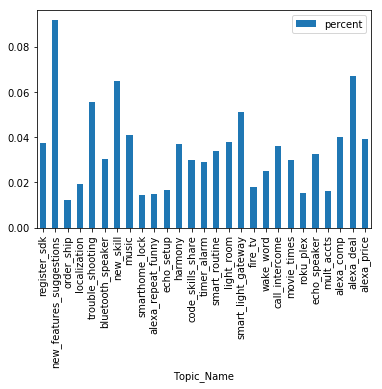

In [48]:
df_merged_new.plot(kind='bar', x='Topic_Name', y='percent')

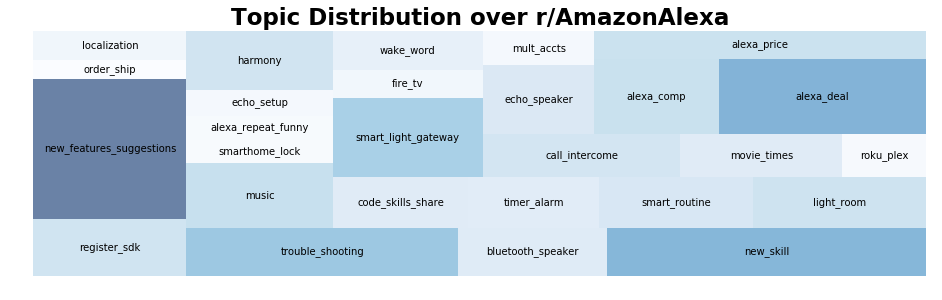

In [57]:
import matplotlib
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)
 
norm = matplotlib.colors.Normalize(vmin=min(df_merged_new.percent), vmax=max(df_merged_new.percent))
colors = [matplotlib.cm.Blues(norm(value)) for value in df_merged_new.percent]

#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 4.5)

#Use squarify to plot our data, label it and add colours. We add an alpha layer to ensure black labels show through
squarify.plot(label=df_merged_new.Topic_Name,sizes=df_merged_new.percent, color = colors, alpha=.6)
plt.title("Topic Distribution over r/AmazonAlexa",fontsize=23,fontweight="bold")

#Remove our axes and display the plot
plt.axis('off')
plt.show()

In [62]:
total = df_merged_new['percent'].sum()
print(total)

0.9354935484351652


small topic weights are not returned in the sparse format. By default, "small" means <0.01.

My guess is you're using a lot of topics, most of them end up only with the tiny prior weights (~alpha), but collectively all these big + small weights add up to 1. But you "see" only the large ones in sparse format.

You can verify whether this is the case by changing the "small" threshold to something even smaller:

print lda_model.__getitem__(bow, eps=0.00001)  # default is 0.01
should add up to 1.0

In [51]:
AlexaFrame.to_pickle('AlexaFrameScore.pickle')

In [31]:
from gensim.models import Word2Vec
GoogleHomeWord2VecModel = Word2Vec(texts, size=100, window=5, min_count=5, workers=4)

DEBUG:gensim.models.word2vec:Fast version of gensim.models.word2vec is being used
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 17143 word types from a corpus of 806597 raw words and 5143 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:min_count=5 retains 4659 unique words (27% of original 17143, drops 12484)
INFO:gensim.models.word2vec:min_count=5 leaves 788220 word corpus (97% of original 806597, drops 18377)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 17143 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 71 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 676991 word corpus (85.9% of prior 788220)
INFO:gensim.models.word2vec:estimated required memory for 4659 words and 100 dimensions: 6056700 bytes
INFO:gensim.models.word2vec:rese

In [288]:
GoogleHomeWord2VecModel.most_similar('routin', topn=150)

[('virt', 0.9153628349304199),
 ('smartap', 0.8726494312286377),
 ('goodnight', 0.8313636779785156),
 ('preform', 0.8204854726791382),
 ('stringify', 0.8145835399627686),
 ('toggl', 0.7864094972610474),
 ('trig', 0.7831201553344727),
 ('mom', 0.7773553133010864),
 ('scen', 0.7766660451889038),
 ('ift', 0.765295684337616),
 ('applet', 0.763493537902832),
 ('phrases', 0.7559260725975037),
 ('sleepy', 0.7551200985908508),
 ('bedtim', 0.7411741018295288),
 ('vol', 0.7363965511322021),
 ('piston', 0.7355259656906128),
 ('puls', 0.7348682284355164),
 ('execut', 0.7283816337585449),
 ('flip', 0.7224534749984741),
 ('conjunct', 0.7156539559364319),
 ('thermost', 0.7151897549629211),
 ('lock', 0.7146139144897461),
 ('cor', 0.7125635743141174),
 ('combin', 0.7115185260772705),
 ('gar', 0.7085720300674438),
 ('chamberlain', 0.7035870552062988),
 ('inst', 0.7023019790649414),
 ('myq', 0.7014288902282715),
 ('fob', 0.6976947784423828),
 ('degr', 0.6966476440429688),
 ('key', 0.6958016157150269),
 (

In [84]:
GoogleHomeFrame.columns

Index(['archived', 'author', 'author_flair_css_class', 'author_flair_text',
       'body', 'controversiality', 'created_utc', 'distinguished', 'downs',
       'edited', 'gilded', 'link_id', 'name', 'parent_id', 'removal_reason',
       'score', 'score_hidden', 'subreddit', 'ups', 'smart_routine', 'NA1',
       'swtich_hub', 'trouble_shooting', 'chromcast', 'thermo_nest',
       'light_ifttt', 'harmony', 'NA2', 'cell_control', 'alarm_vol',
       'router_wifi', 'cast_tv_smart', 'NA3', 'radio_tunein', 'localization',
       'NA4', 'youtube_red', 'shop_list', 'echo_home_comp', 'netflix_skin',
       'music_spot', 'NA5', 'IFTTT_rep', 'chrom_netflix_tv',
       'calend_mult_accts', 'wake_word', 'light_room', 'order_ship', 'NA6'],
      dtype='object')

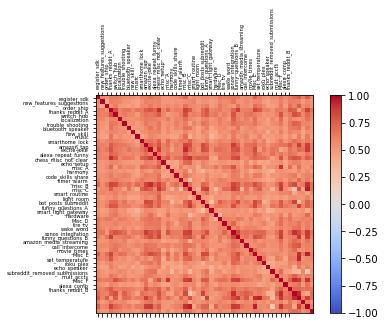

In [50]:
import matplotlib.pyplot as plt
import pandas
import numpy
data = AlexaFrame
names = ['register_sdk', 'new_features_suggestions', 'order_ship', 'thanks_reddit_A', 'switch_hub', 'localization', 'trouble_shooting', 'bluetooth_speaker', 'new_skill', \
              'music', 'smarthome_lock', 'amazon_tap', 'excite-joke', 'alexa_repeat_funny', 'chess_misc_not_clear', 'echo_setup', 'misc_A',\
              'harmony', 'code_skills_share', 'timer_alarm','misc_B', 'misc_C', 'smart_routine', 'light_room',\
              'bot_posts_subreddit', 'funny_questions_A', 'smart_light_gateway', 'hardware', 'Misc_D','fire_tv', 'wake_word','sonos_integration','funny_questions_B',\
              'amazon_media_streaming','call_intercome','movie_times','Misc_E','set_temperature', 'roku_plex', 'echo_speaker', 'subreddit_removed_submissions', 'mult_accts', 'Misc_F',\
              'alexa_comp','thanks_reddit_B', 'thanks_reddit_C','Misc_G','alexa_deal','Misc_H','alexa_price']
data = data[names]
correlations = data.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1, cmap = 'coolwarm')
fig.colorbar(cax)
ticks = numpy.arange(0,45,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names, rotation = 90, fontsize = 5)
ax.set_yticklabels(names, fontsize = 5)
plt.show()


In [56]:
AlexaFrame.to_pickle('dfamazon_March1.pickle')